In [2]:
#optimized first-order method
import numpy as np
from scipy.signal import fftconvolve
from scipy.linalg import svd, diagsvd
from scipy.linalg import norm
from datetime import datetime
from astropy.io import fits
from os import remove
from subprocess import check_call
import matplotlib.pyplot as plt

'''
DEFINE FUNCTIONS

'''
def sigma_mad(a):

    return 1.4826 * np.median(np.abs(a - np.median(a)))

def prox_op(a):

    return a * (a > 0)

def rotate(data):
    
    return np.rot90(data, 2)

def rotate_stack(data):
    
    return np.array([rotate(x) for x in data ])

def convolve(a, b):
    
    return fftconvolve(a, b, mode='same')

def convolve_stack(a, b):

    return np.array([convolve(i, j) for i, j in zip(a, b)])
def filter_convolve(data, filters, filter_rot=False):
   
    if filter_rot:
        return np.sum((convolve(coef, f) for coef, f in
                      zip(data, rotate_stack(filters))), axis=0)

    else:
        return np.array([convolve(data, f) for f in filters])


def filter_convolve_stack(data, filters, filter_rot=False):

    return np.array([filter_convolve(x, filters, filter_rot=filter_rot)
                     for x in data])

def get_grad(x, y, psf, psf_rot):
    
    return convolve_stack(convolve_stack(x, psf) - y, psf_rot) 

def soft(a, level):

    return np.sign(a) * (np.abs(a) - level) * (np.abs(a) >= level)

def nmse(image1, image2, metric=np.mean):


    if image1.ndim != image2.ndim:
        raise ValueError('Input images must have the same dimensions')

    if image1.ndim not in (2, 3):
        raise ValueError('Input data must be single image or stack of images')

    if image1.ndim == 2:

        return (np.linalg.norm(image2 - image1) ** 2 /
                np.linalg.norm(image1) ** 2)

    else:

        res = (np.array([np.linalg.norm(x) ** 2 for x in (image2 - image1)]) /
               np.array([np.linalg.norm(x) ** 2 for x in image1]))

        return metric(res)

def call_mr_transform(data, opt=None, path='./', remove_files=True):
    
    #this method calls the iSAP module mr_transform
    
    # Create a unique string using the current date and time.
    unique_string = datetime.now().strftime('%Y.%m.%d_%H.%M.%S')
    
    # Set the ouput file names.
    file_name = path + 'mr_temp_' + unique_string
    file_fits = file_name + '.fits'
    file_mr = file_name + '.mr'

    # Write the input data to a fits file.
    fits.writeto(file_fits, data)
    
    # Call mr_transform.
    if isinstance(opt, type(None)):
        check_call(['mr_transform', file_fits, file_mr])
    else:
        check_call(['mr_transform'] + opt + [file_fits, file_mr])

    # Retrieve wavelet transformed data.
    result = fits.getdata(file_mr)

    # Return the mr_transform results (and the output file names).
    if remove_files:
        remove(file_fits)
        remove(file_mr)
        return result
    else:
        return result, file_mr  
    
def get_mr_filters(data_shape, opt=None, coarse= False):
    
    #adjust the shape of the input data
    data_shape = np.array(data_shape)
    data_shape += data_shape%2 - 1
    
    #create fake data
    fake_data = np.zeros(data_shape)
    fake_data[zip(data_shape/2)] = 1
    
    #get the mr_filter
    mr_filters = call_mr_transform(fake_data, opt=opt)
    
    if coarse:
       return mr_filters
    else:
       return mr_filters[:-1]

class cwbReweight(object):
    
    def __init__(self, weights, thresh_factor=1):

        self.weights = weights
        self.original_weights = np.copy(self.weights)
        self.thresh_factor = thresh_factor

    def reweight(self, data):
        
        """
        Reweighting implemented as w = w (1 / (1 + |x^w|/(n * sigma)))

        """

        self.weights *= (1.0 / (1.0 + np.abs(data) / (self.thresh_factor *
                         self.original_weights)))
        return self.weights

def get_weight(data,psf):
    
    noise_est = sigma_mad(data)
    wave_thresh_factor = [3.0, 3.0, 4.0]
    data_shape = data.shape[-2:] #[41,41]
    
    mr_filters = get_mr_filters(data_shape, opt=None, coarse= False)#[3,41,41]
    
    filter_conv = (filter_convolve_stack(np.rot90(psf, 2),
                       mr_filters))#[100,3,41,41]
    filter_norm = np.array([[norm(b) * c * np.ones(data_shape[1:])
                                for b, c in zip(a, wave_thresh_factor)]
                                for a in filter_conv])
 
    weight0 = noise_est * filter_conv
    weight = cwbReweight(weight0)

    return weight.weights

def denoise(data, level, threshold_type='hard'):
    
    if threshold_type not in ('hard', 'soft'):
        raise ValueError('Invalid threshold type. Options are "hard" or'
                         '"soft"')

    if threshold_type == 'soft':
        return np.sign(data) * (np.abs(data) - level) * (np.abs(data) >= level)

    else:
        return data * (np.abs(data) >= level)   

class Threshold(object):
    """
    Threshold proximity operator for update the weight and apply the proximity

    """

    def __init__(self, weights):

        self.update_weights(weights)

    def update_weights(self, weights):
       

        self.weights = weights

    def op(self, data, extra_factor=1.0):

        threshold = self.weights * extra_factor

        return denoise(data, threshold, 'soft')
#%%
def prox_dual_op_s(a, thresh):
    
    return soft(a, thresh)

def linear_op(data):
    
    data_shape = data.shape[-2:]
    mr_filters = get_mr_filters(data_shape, opt=None, coarse= False)
    linear_data = filter_convolve_stack(data, mr_filters)
    
    return linear_data

def linear_op_inv(data):
     
    data_shape = data.shape[-2:]
    mr_filters = get_mr_filters(data_shape, opt=None, coarse= False)
    linear_data_inv = filter_convolve_stack(data, mr_filters, filter_rot=True)
    
    return linear_data_inv

def get_cost(x, data, psf, thresh):
    
    data_shape = data.shape[-2:]
    mr_filters = get_mr_filters(data_shape, opt=None, coarse= False)
    l1_norm = thresh*filter_convolve_stack(x, mr_filters)
    l1_norm = np.sum(np.abs(l1_norm))
    print "get_cost:"
    df = ((convolve_stack(x, psf) - data)**2).sum()
    return (0.5*df + l1_norm)

def get_cost_new(x, data, psf, thresh):
    print "get_cost:"
    df = np.linalg.norm((convolve_stack(x, psf) - data))**2
    return df



In [ ]:
data = np.load('Latest_PSFs_Peipei/galaxies_obs_SNR_vlow.npy')
data_true = np.load('Latest_PSFs_Peipei/galaxies_tru.npy')
psf = np.load('Latest_PSFs_Peipei/PSF_tru.npy')
x = np.copy(data)
y = np.copy(data)
T = []
costs = []
n = 0
n_iter_reweight = 2
n_iter = 1000
L = 1 + 1.6e-4
init_cost = 1e6
tolerance = 1e-6

psf_rot = rotate_stack(psf)

thresh = get_weight(data, psf)

tmp = 1
T.append(tmp)
tmp = 1
T.append(tmp)

for iter_num_reweight in xrange(0, n_iter_reweight):
    
    for iter_num in xrange(1, n_iter):
        
        x_update = y - (1/L) * get_grad(y, data, psf, psf_rot)
        x_update = prox_op(x_update)
        x_update = linear_op(x_update)
        x_update = soft(x_update, thresh)
        x_update  = linear_op_inv(x_update)
        
        tmp = (1 + (1 + 4 * (tmp**2))**0.5)/2
        T.append(tmp)
        y_update = x_update + (T[-3]/T[-1]) * (x_update - x) + (T[-2]/T[-1]) * (x_update - y) 
        x = x_update
        y = y_update
        
        tmp1 = get_cost(x_update, data, psf, thresh)
        costs.append(tmp1)
        print iter_num, 'COST:', costs[-1]
        print ''
        if not iter_num % 4:
            cost_diff = np.linalg.norm(np.mean(costs[-4:-2]) - np.mean(costs[-2:]))
            print ' - COST DIFF:', cost_diff
            print ''

            if cost_diff < tolerance:
                
                print 'Converged!'
                nmse_data = nmse(data_true, x, metric=np.median)
                print 'nmse_data', nmse_data
                print ''
                break
       
    thresh = get_weight(x,psf)


get_cost:
1 COST: 3.32186465914

get_cost:
2 COST: 5.40705844186

get_cost:
3 COST: 4.6793906608

get_cost:
4 COST: 4.93665730685

 - COST DIFF: 0.443562433326

get_cost:
5 COST: 4.89742798366

get_cost:
6 COST: 4.9987491498

get_cost:
7 COST: 4.95786604106

get_cost:
8 COST: 5.00389498719

 - COST DIFF: 0.0327919473919

get_cost:
9 COST: 4.97711523772

get_cost:
10 COST: 4.9958017421

get_cost:
11 COST: 4.98105403732

get_cost:
12 COST: 4.99499751906

 - COST DIFF: 0.00156728828132

get_cost:
13 COST: 4.9854247939

get_cost:
14 COST: 4.99353143449

get_cost:
15 COST: 4.98696836717

get_cost:
16 COST: 4.98924917576

 - COST DIFF: 0.00136934273067

get_cost:
17 COST: 4.98648322233

get_cost:
18 COST: 4.98876980964

get_cost:
19 COST: 4.98547938117

get_cost:
20 COST: 4.98587338115

 - COST DIFF: 0.00195013482106

get_cost:
21 COST: 4.98390072695

get_cost:
22 COST: 4.9850594511

get_cost:
23 COST: 4.98262966856

get_cost:
24 COST: 4.98335514383

 - COST DIFF: 0.00148768283201

get_cost:

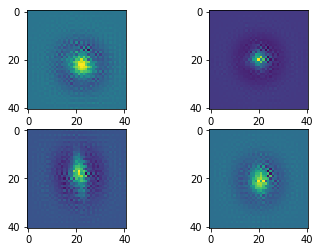

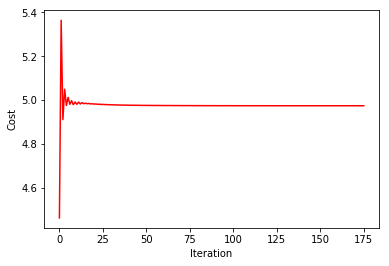

In [46]:
# DISPLAY SOME IMAGES
plt.figure(1)
plt.subplot(221)
plt.imshow(x[8], interpolation='nearest')
plt.subplot(222)
plt.imshow(x[18], interpolation='nearest')
plt.subplot(223)
plt.imshow(x[28], interpolation='nearest')
plt.subplot(224)
plt.imshow(x[38], interpolation='nearest')
plt.show()

# DISPLAY COST FUNCTION DECAY
plt.figure(2)
plt.plot(range(len(costs)), costs, 'r-')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

In [47]:
T


[1,
 1,
 1.618033988749895,
 2.193527085331054,
 2.749791340120445,
 3.2948796779470473,
 3.83260140013,
 4.365078717475032,
 4.8936217645302005,
 5.419098898607719,
 5.942116580237085,
 6.463115750438564,
 6.982427415989093,
 7.500306608967648,
 8.016954119091308,
 8.53253094283583,
 9.047168203004484,
 9.56097414704707,
 10.074039201951413,
 10.586439701027011,
 11.098240681522611,
 11.609498018587676,
 12.120260076417877,
 12.630569002318444,
 13.14046175273386,
 13.64997091536941,
 14.159125374284798,
 14.667950852706811,
 15.176470359641057,
 15.684704560084912,
 16.192672084038094,
 16.700389786088067,
 17.20787296478144,
 17.71513554904683,
 18.222190257445686,
 18.72904873487776,
 19.235721670472856,
 19.742218899698106,
 20.248549493155114,
 20.754721834099627,
 21.260743686362773,
 21.76662225406786,
 22.27236423430589,
 22.77797586374463,
 23.28346295999212,
 23.78883095840848,
 24.29408494495499,
 24.799229685582393,
 25.304269652587454,
 25.80920904830608,
 26.314051826460

[  1.67813001e-05   2.19319937e-05   2.70099058e-05   4.41064473e-05
   5.73139897e-05   6.10423787e-05   8.52474608e-05   8.67809753e-05
   1.13838703e-04   1.47748422e-04   2.03303180e-04   2.99234325e-04
   4.04588357e-04   7.34462865e-04   1.09400011e-03   1.53392193e-03
   2.05049296e-03   2.75799947e-03   3.43876502e-03   3.76201326e-03
   3.69249823e-03   3.32653507e-03   2.67904097e-03   1.95937166e-03
   1.35906248e-03   1.04372531e-03   5.84121385e-04   3.98193995e-04
   1.32139108e-04   2.11133997e-04   3.52755599e-05   1.44038599e-04
   6.01814591e-05   1.04087481e-04   1.03125460e-04   5.27399536e-05
   5.45264748e-05   3.87782243e-05   3.74525334e-06   8.03033330e-06
   3.64442257e-06]


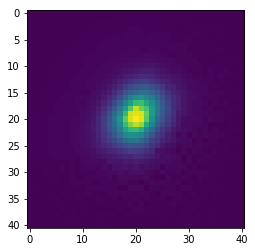

In [41]:
x_update = y - (0.5/L) * get_grad(y, data, psf, psf_rot)
print x_update[45][23]
plt.imshow(x_update[45])
plt.show() 

[-0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.01454784  0.04448509  0.0052414  -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]


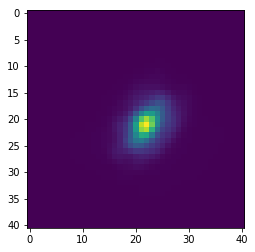

In [44]:
data_true = np.load('Latest_PSFs_Peipei/galaxies_tru.npy')
print data_true[45][23]
plt.imshow(data[45])
plt.show()


In [23]:
print data_true[1][1]

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0.]
